In [16]:
import pandas as pd
import numpy as np
import os 
import cv2
import pydicom
import scipy.ndimage
from scipy.spatial.distance import pdist
from matplotlib import pyplot as plt

import shutil
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import backend as K
import keras
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tensorflow.keras import layers
import seaborn as sns

In [17]:
def load_dicom(path2scan_dir):
    dicom_folder = path2scan_dir
    dcms = os.listdir(dicom_folder)
    first_slice_data = pydicom.read_file(os.path.join(path2scan_dir,dcms[0]))
    first_slice = first_slice_data.pixel_array
    orientation = np.transpose(first_slice_data.ImageOrientationPatient) #zyx format
    spacing_xy = np.array(first_slice_data.PixelSpacing, dtype=float)
    spacing_z = float(first_slice_data.SliceThickness)
    spacing = np.array([spacing_z, spacing_xy[1], spacing_xy[0]]) #zyx format

    scan = np.zeros((len(dcms),first_slice.shape[0],first_slice.shape[1]))
    raw_slices=[]
    indexes = []
    for dcm in dcms:
        slice_data = pydicom.read_file(os.path.join(dicom_folder,dcm))
        slice_data.filename = dcm
        raw_slices.append(slice_data)
        indexes.append(float(slice_data.ImagePositionPatient[2]))
    indexes = np.array(indexes,dtype=float)

    raw_slices = [x for _, x in sorted(zip(indexes, raw_slices))]
    origin = np.array(raw_slices[0][0x00200032].value) #origin is assumed to be the image location of the first slice
    if origin is None:
        origin = np.zeros(3)
    else:
        origin = np.array([origin[2],origin[1],origin[0]]) #change from x,y,z to z,y,x

    for i, slice in enumerate(raw_slices):
        scan[i, :, :] = slice.pixel_array
    return scan, spacing, orientation, origin, raw_slices

In [18]:
# loading a image from blind category
scan_uuid = 8038
scan, spacing, orientation, origin, raw_slices = load_dicom('../input/medical-deepfakes-lung-cancer/CT_Scans/EXP1_blind/'+str(scan_uuid))

#scan_uuid = 1563
#scan, spacing, orientation, origin, raw_slices = load_dicom('../input/medical-deepfakes-lung-cancer/CT_Scans/EXP2_open/'+str(scan_uuid))

print('The CT scan has the dimensions of',scan.shape,'  (z,y,x)')

The CT scan has the dimensions of (249, 512, 512)   (z,y,x)


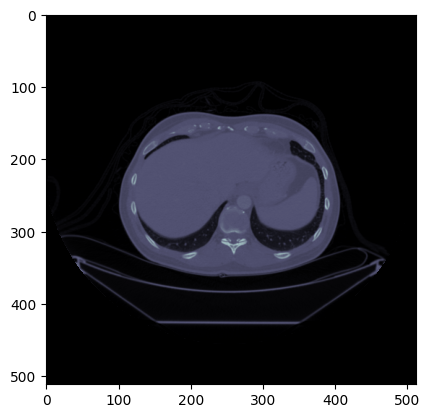

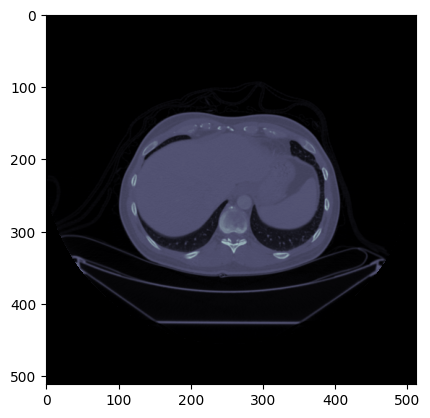

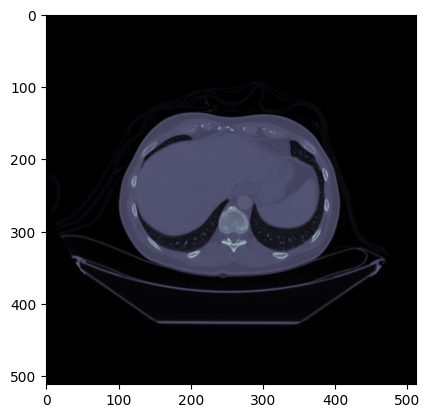

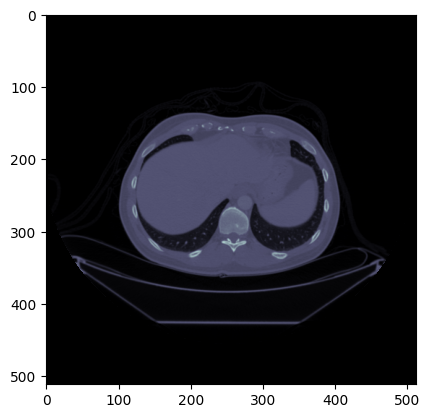

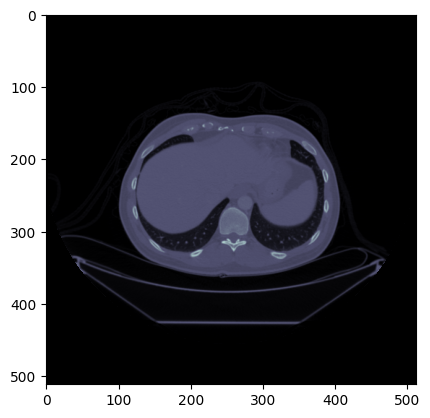

In [19]:
# displaying the images
for slice_indx in range(50,55,1):
    plt.imshow(scan[slice_indx,:,:],cmap='bone',vmin=-1000,vmax=2000)
    plt.show()

In [20]:
labels = pd.read_csv("../input/medical-deepfakes-lung-cancer/labels_exp2.csv")

In [21]:
# few images from TM and FM 
scan_uuids = [4142, 2838, 2320, 5614]
scan_uuids = [4635, 2031, 2590, 1796]

finalImagesFM = None
for scan_uuid in scan_uuids:
#     FM_scan, spacing, orientation, origin, raw_slices = load_dicom('../input/medical-deepfakes-lung-cancer/CT_Scans/EXP1_blind/'+str(scan_uuid))
    FM_scan, spacing, orientation, origin, raw_slices = load_dicom('../input/medical-deepfakes-lung-cancer/CT_Scans/EXP2_open/'+str(scan_uuid))
    if finalImagesFM is not None:
        finalImagesFM = np.concatenate((finalImagesFM, FM_scan))
    else:
        finalImagesFM = FM_scan

In [22]:
finalImagesFM.shape

(996, 512, 512)

In [23]:
scan_uuids = [2190, 7507, 3025, 3099]
scan_uuids = [2199, 2575, 2495, 2220]
finalImagesTM = None
for scan_uuid in scan_uuids:
#     TM_scan, spacing, orientation, origin, raw_slices = load_dicom('../input/medical-deepfakes-lung-cancer/CT_Scans/EXP1_blind/'+str(scan_uuid))
    TM_scan, spacing, orientation, origin, raw_slices = load_dicom('../input/medical-deepfakes-lung-cancer/CT_Scans/EXP2_open/'+str(scan_uuid))
    if finalImagesTM is not None:
        finalImagesTM = np.concatenate((finalImagesTM, TM_scan))
    else:
        finalImagesTM = TM_scan

In [24]:
finalImagesTM.shape

(1427, 512, 512)

In [25]:
finalImages = np.concatenate((finalImagesFM, finalImagesTM))
finalLabels = ['fake'] * finalImagesFM.shape[0] + ['real'] * finalImagesTM.shape[0]

In [26]:
finalImages.shape, len(finalLabels)

((2423, 512, 512), 2423)

In [27]:
resized_masks = np.empty([finalImages.shape[0], 224, 224])

In [28]:
for i in range(finalImages.shape[0]):
    resized_masks[i] = cv2.resize(np.copy(finalImages[i]), ( 224, 224))


In [29]:
resized_masks.shape

(2423, 224, 224)

In [30]:
X_train, X_test, y_train, y_test = train_test_split(
    resized_masks,
    finalLabels,
    test_size=0.2,
    random_state=42,
)

X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

print(('X_train:', X_train.shape))
print(('y_train:', y_train.shape))
print(('X_test:', X_test.shape))
print(('y_test:', y_test.shape))

('X_train:', (1938, 224, 224))
('y_train:', (1938,))
('X_test:', (485, 224, 224))
('y_test:', (485,))


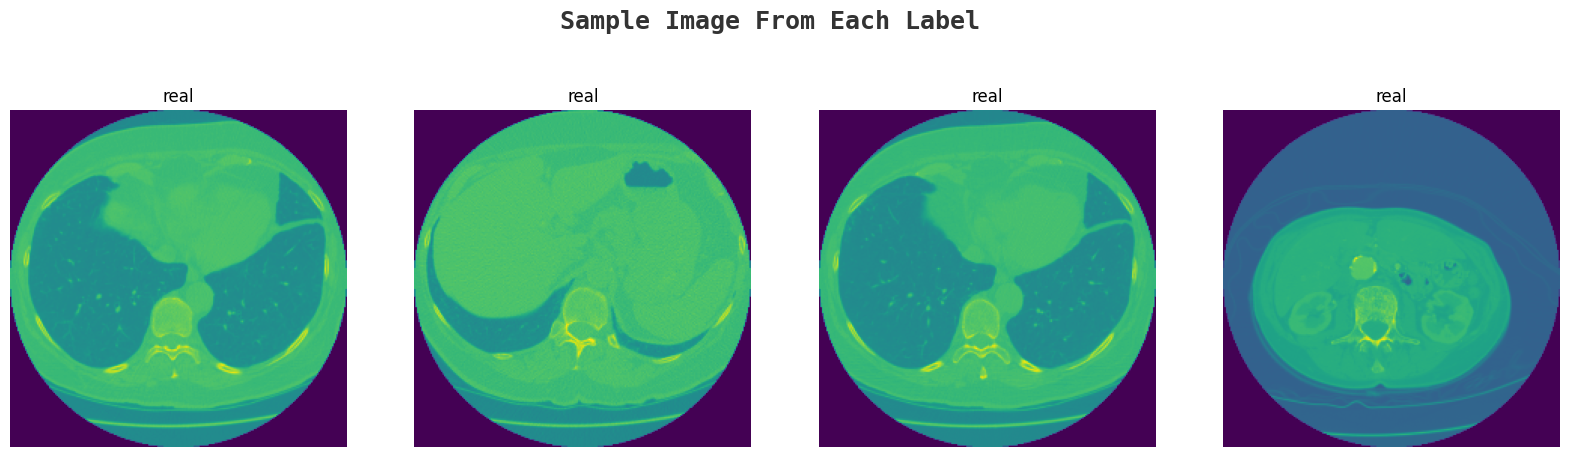

In [31]:
# displaying training images
k = 0
fig, ax = plt.subplots(1, 4, figsize=(20, 20))
fig.text(s='Sample Image From Each Label',
         size=18,
         fontweight='bold',
         fontname='monospace',
         y=0.62,
         x=0.4,
         alpha=0.8)
for j in [0,1,409,385]:
    while True:
        ax[k].imshow(X_train[j])
        ax[k].set_title(y_train[j])
        ax[k].axis('off')
        k += 1
        break


In [32]:
def conv_block(inputs, filters, kernel_size, strides):
    x = layers.Conv2D(filters, kernel_size, strides=strides, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    return x

def inverted_residual_block(inputs, filters, expansion, kernel_size, strides):
    # Depthwise convolution
    x = layers.DepthwiseConv2D(kernel_size, strides=strides, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # Pointwise convolution
    x = layers.Conv2D(filters, kernel_size=(1, 1), strides=(1, 1), padding='same')(x)
    x = layers.BatchNormalization()(x)

    # Add shortcut connection if the input and output shapes are the same
    if strides == 1 and inputs.shape[-1] == filters:
        x = layers.Add()([x, inputs])

    return x

def build_mobilenetv2(input_shape=(224, 224, 3), num_classes=1000):
    input_tensor = layers.Input(shape=input_shape)

    x = conv_block(input_tensor, filters=32, kernel_size=(3, 3), strides=(2, 2))

    x = inverted_residual_block(x, filters=16, expansion=1, kernel_size=(3, 3), strides=(1, 1))
    x = inverted_residual_block(x, filters=24, expansion=6, kernel_size=(3, 3), strides=(2, 2))
    x = inverted_residual_block(x, filters=24, expansion=6, kernel_size=(3, 3), strides=(1, 1))
    x = inverted_residual_block(x, filters=32, expansion=6, kernel_size=(3, 3), strides=(2, 2))
    x = inverted_residual_block(x, filters=32, expansion=6, kernel_size=(3, 3), strides=(1, 1))
    x = inverted_residual_block(x, filters=64, expansion=6, kernel_size=(3, 3), strides=(1, 1))
    x = inverted_residual_block(x, filters=64, expansion=6, kernel_size=(3, 3), strides=(1, 1))
    x = inverted_residual_block(x, filters=64, expansion=6, kernel_size=(3, 3), strides=(1, 1))
    x = inverted_residual_block(x, filters=96, expansion=6, kernel_size=(3, 3), strides=(1, 1))
    x = inverted_residual_block(x, filters=96, expansion=6, kernel_size=(3, 3), strides=(1, 1))
    x = inverted_residual_block(x, filters=96, expansion=6, kernel_size=(3, 3), strides=(1, 1))
    x = inverted_residual_block(x, filters=160, expansion=6, kernel_size=(3, 3), strides=(2, 2))
    x = inverted_residual_block(x, filters=160, expansion=6, kernel_size=(3, 3), strides=(1, 1))
    x = inverted_residual_block(x, filters=160, expansion=6, kernel_size=(3, 3), strides=(1, 1))
    x = inverted_residual_block(x, filters=320, expansion=6, kernel_size=(3, 3), strides=(1, 1))

    x = conv_block(x, filters=1280, kernel_size=(1, 1), strides=(1, 1))
    x = layers.GlobalAveragePooling2D()(x)
    x = layers.Dense(num_classes, activation='softmax')(x)

    model = tf.keras.Model(inputs=input_tensor, outputs=x)
    return model

# Example usage
input_shape = (224, 224, 1)
num_classes = 1
model1 = build_mobilenetv2(input_shape, num_classes)

In [33]:
model = MobileNetV2(input_shape=[128, 128, 1], alpha=1, weights=None, classes=1)

In [34]:
model1.compile(loss='categorical_crossentropy', 
              optimizer='adam',
              metrics=['accuracy'])

In [35]:
model1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 112, 112, 32)      320       
                                                                 
 batch_normalization (Batch  (None, 112, 112, 32)      128       
 Normalization)                                                  
                                                                 
 re_lu (ReLU)                (None, 112, 112, 32)      0         
                                                                 
 depthwise_conv2d (Depthwis  (None, 112, 112, 32)      320       
 eConv2D)                                                        
                                                                 
 batch_normalization_1 (Bat  (None, 112, 112, 32)      128   

In [36]:
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

In [37]:
X_train.shape

(1938, 224, 224)

In [38]:
hist = model1.fit(x=X_train[:1000],
                 y=y_train[:1000],
                 batch_size=128,
                 epochs=10,
                 validation_data=(X_test, y_test),
                 verbose=2)

Epoch 1/10


/opt/conda/lib/python3.10/site-packages/tensorflow/python/util/dispatch.py:1176: SyntaxWarning: In loss categorical_crossentropy, expected y_pred.shape to be (batch_size, num_classes) with num_classes > 1. Received: y_pred.shape=(None, 1). Consider using 'binary_crossentropy' if you only have 2 classes.
  return dispatch_target(*args, **kwargs)


8/8 - 56s - loss: 0.0000e+00 - accuracy: 0.5850 - val_loss: 0.0000e+00 - val_accuracy: 0.5753 - 56s/epoch - 7s/step
Epoch 2/10
8/8 - 42s - loss: 0.0000e+00 - accuracy: 0.5850 - val_loss: 0.0000e+00 - val_accuracy: 0.5753 - 42s/epoch - 5s/step
Epoch 3/10
8/8 - 42s - loss: 0.0000e+00 - accuracy: 0.5850 - val_loss: 0.0000e+00 - val_accuracy: 0.5753 - 42s/epoch - 5s/step
Epoch 4/10
8/8 - 43s - loss: 0.0000e+00 - accuracy: 0.5850 - val_loss: 0.0000e+00 - val_accuracy: 0.5753 - 43s/epoch - 5s/step
Epoch 5/10
8/8 - 43s - loss: 0.0000e+00 - accuracy: 0.5850 - val_loss: 0.0000e+00 - val_accuracy: 0.5753 - 43s/epoch - 5s/step
Epoch 6/10
8/8 - 42s - loss: 0.0000e+00 - accuracy: 0.5850 - val_loss: 0.0000e+00 - val_accuracy: 0.5753 - 42s/epoch - 5s/step
Epoch 7/10
8/8 - 42s - loss: 0.0000e+00 - accuracy: 0.5850 - val_loss: 0.0000e+00 - val_accuracy: 0.5753 - 42s/epoch - 5s/step
Epoch 8/10
8/8 - 42s - loss: 0.0000e+00 - accuracy: 0.5850 - val_loss: 0.0000e+00 - val_accuracy: 0.5753 - 42s/epoch - 5s/

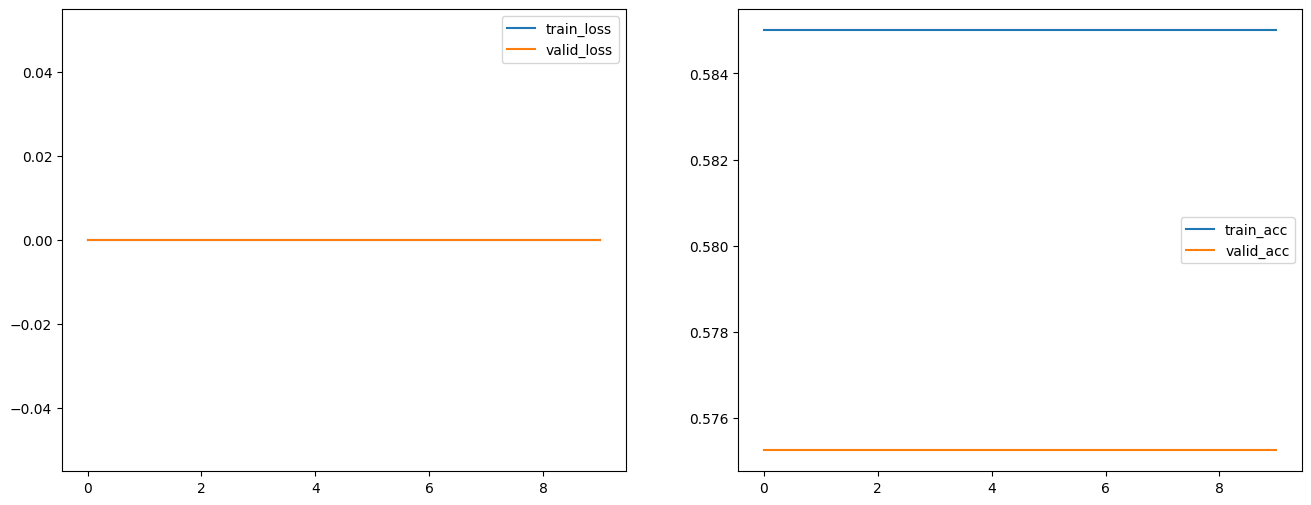

In [39]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=[16, 6])
ax1.plot(hist.history['loss'], label='train_loss')
ax1.plot(hist.history['val_loss'], label='valid_loss')
ax1.legend()
ax2.plot(hist.history['accuracy'], label='train_acc')
ax2.plot(hist.history['val_accuracy'], label='valid_acc')
ax2.legend()

In [40]:
y_pred = model1.predict(X_test)

print(('Prediction shape:', y_pred.shape))
print(('Accuracy:', accuracy_score(y_test, np.argmax(y_pred, axis=1))))

16/16 [==============================] - 4s 217ms/step
('Prediction shape:', (485, 1))
('Accuracy:', 0.4247422680412371)


In [41]:
print(classification_report(y_test, np.argmax(y_pred, axis=1)))

              precision    recall  f1-score   support

           0       0.42      1.00      0.60       206
           1       0.00      0.00      0.00       279

    accuracy                           0.42       485
   macro avg       0.21      0.50      0.30       485
weighted avg       0.18      0.42      0.25       485



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [42]:
cm = confusion_matrix(y_test, np.argmax(y_pred, axis=1))

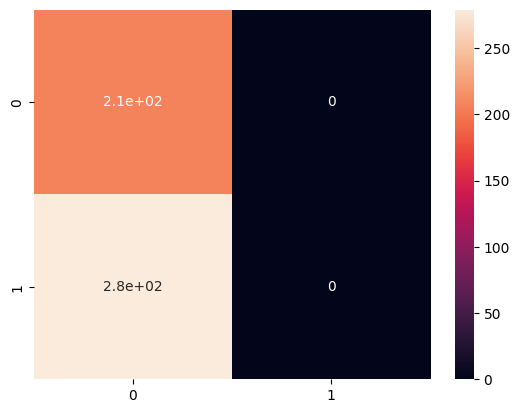

In [43]:
sns.heatmap(cm, annot=True)
plt.show()